In [12]:
import numpy as np
import pandas as pd
import emoji
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

%matplotlib inline

Using TensorFlow backend.


In [5]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',  encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def label_to_emoji(label):

    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              
    
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))
        
        
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    
def predict(X, Y, W, b, word_to_vec_map):

    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [3]:

def sentence_to_avg(sentence, word_to_vec_map):

    words = sentence.lower().split()
    avg = np.zeros((50, ))
    
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    return avg

# GRADED FUNCTION: model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    
    np.random.seed(1)

    m = Y.shape[0]                          
    n_y = 5                                 
    n_h = 50                                
    
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    for t in range(num_iterations):                       
        for i in range(m):                               
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W, avg) + b
            a = softmax(z)
            cost = -np.sum(Y_oh[i] * np.log(a))
            
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [6]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')
maxLen = len(max(X_train, key=len).split())
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.95204988128
Accuracy: 0.348484848485
Epoch: 100 --- cost = 0.0797181872601
Accuracy: 0.931818181818
Epoch: 200 --- cost = 0.0445636924368
Accuracy: 0.954545454545
Epoch: 300 --- cost = 0.0343226737879
Accuracy: 0.969696969697
[[ 3.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 

In [8]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Training set:
Accuracy: 0.977272727273
Test set:
Accuracy: 0.857142857143
Accuracy: 0.833333333333

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


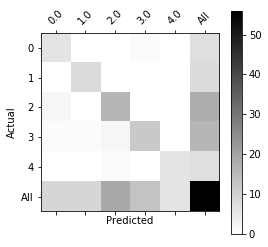

In [11]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [13]:
def sentences_to_indices(X, word_to_index, max_len):

    m = X.shape[0]                              
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                              
        sentence_words =X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):

    
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
   
    sentence_indices = Input(input_shape, dtype = "int32")
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(128, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences = False)(X)
    X = Dropout(0,5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)

    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [14]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 8s 58ms/step - loss: 1.5833 - acc: 0.3258
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 1.5090 - acc: 0.3258
Epoch 3/50
132/132 [==============================] - 1s 4ms/step - loss: 1.4162 - acc: 0.5076
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 1.2925 - acc: 0.5985
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 1.1450 - acc: 0.6364
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.9484 - acc: 0.6970
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.8672 - acc: 0.7045
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.7476 - acc: 0.7348
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.6114 - acc: 0.7803
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.7563 - acc: 0.7576
Epoch 11/50
132/132 [===========================

In [16]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 5s 81ms/step

Test accuracy =  0.874999991485


In [20]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:❤️ prediction: I love you to the stars and back	😄
Expected emoji:😞 prediction: go away	⚾


In [21]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞
